In [120]:
from importlib import reload  
import numpy as np
import matplotlib.pyplot as plt
import pycraf
import cysgp4
import astropy.coordinates as coord
from pycraf import conversions as cnv
from pycraf import protection, antenna, geometry,satellite
from astropy import units as u, constants as const
import glob
from scepter import skynet,obs,tlefinder
from astropy.coordinates import EarthLocation,SkyCoord
from astropy.time import Time
from astropy import units as u

from astropy.coordinates import AltAz, ICRS
from matplotlib.gridspec import GridSpec
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
import itertools

In [121]:

###reload here
reload(skynet)
reload(obs)
longitude = coord.Angle("11d55m11s").deg
latitude = coord.Angle("+57d23m37s").deg
elevation = 16 * u.m


loc1 = EarthLocation(longitude, latitude, elevation)
ant1=cysgp4.PyObserver(longitude,latitude,elevation.to(u.km).value)

# baseline=75 *u.m### m
longitude = coord.Angle("11d55m15s").deg
latitude = coord.Angle("+57d23m20s").deg
elevation = 16 * u.m
ant2=cysgp4.PyObserver(longitude,latitude,elevation.to(u.km).value)
loc2 = EarthLocation(longitude, latitude, elevation)

longitude = coord.Angle("11d40m08s").deg
latitude = coord.Angle("+57d30m20s").deg
elevation = 50 * u.m
ant3=cysgp4.PyObserver(longitude,latitude,elevation.to(u.km).value)
loc3 = EarthLocation(longitude, latitude, elevation)

observers = np.array([ant1,ant2,ant3])

# x1,y1,z1 = pycraf.geospatial.wgs84_to_itrf2008(ant1.loc.lon*u.deg, ant1.loc.lat*u.deg, ant1.loc.alt*u.m)
# print(x1.value,y1,z1)

In [60]:
bearings,baselines = obs.baseline_pairs(observers)

for i in range(len(observers)):
    print(bearings[i],(baselines[i]))


###load the TLEs

[0. 0. 0.] 0.0
[ 419.64819316  156.8758647  -283.40671509] 530.1264086074316
[ -7208.65330539 -16889.39096622   6707.80094833] 19550.212358167264


In [61]:
niters = 1
pydt = cysgp4.PyDateTime() ## take current date and time
start_times_window = 24 * u.hour
time_range, time_resol = 10*u.s, 1e-1*u.s  # seconds
epochiters=time_range/time_resol

# print(start_times,td)
mjds = skynet.plantime(niters,start_times_window,time_range,time_resol,pydt)
print(mjds.shape)

(1, 1, 1, 1, 100, 1)


In [62]:
##load some tle from starlink
import requests
url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle'
ctrak_starlink = requests.get(url).text

tle_list = cysgp4.tle_tuples_from_text(ctrak_starlink)

In [63]:
tles = np.array([
    cysgp4.PyTle(*tle) for tle in tle_list
    ])  # use which TLEs
tles=np.random.choice(a=tles,size=1000)
print (f'we are simulating {tles.shape[0]} satellites over {niters*start_times_window.to_value(u.day)} days,')
print(f'each day/epoch contains {epochiters} integrations over {time_range} seconds')
print(tles.shape)

we are simulating 1000 satellites over 1.0 days,
each day/epoch contains 100.0 integrations over 10.0 s seconds
(1000,)


In [83]:
min_elevation = 30* u.deg
grid_size = .5 * u.deg
npoints=1 ##pointing per cell
skygrid = skynet.pointgen(niters=npoints,
    step_size=grid_size,
    lat_range=(min_elevation, 50 * u.deg),
    lon_range=(140*u.deg,200*u.deg),
    rnd_seed=0,
    )

tel_az, tel_el, grid_info = skygrid 
print(tel_az.shape,grid_info["cell_lon_high"].shape)


tx=obs.transmitter_info(p_tx_carrier=-44 * cnv.dBm, carrier_bandwidth=250*u.MHz, duty_cycle=100 * u.percent, d_tx=1*u.m,freq=10.95*u.GHz)
p_tx=tx.power_tx(10.7*u.GHz)
print(p_tx)


(1, 3659) (3659,)
-27.68556230986828 dB(mW)


In [84]:
dish=13.2*u.m
eta=0.7 *100*u.percent ## in percentage
### frequency band
## transmitter parameters
sat_antenna=0.1*u.m
### observatory list will be passed on internally like this

rx=obs.receiver_info(dish,eta,observers,freq=10.7*u.GHz,bandwidth=2*u.GHz)

1.2589254117941673 W / (Hz m2)


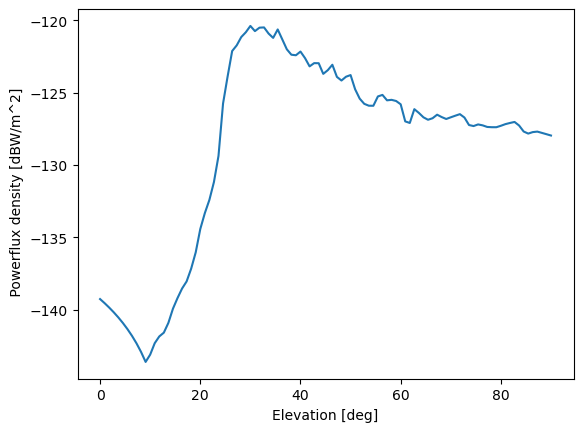

In [85]:
el_response=pd.read_csv('starlink_statistical_pfd.csv')
x_el=el_response['el'].values
y_spfd=el_response['psd_dBW_m2_4khz'].values  ### spectral powerflux density

scale4khz=50e6/4e3 ###4kHz to 1 Hz 
print((1*cnv.dB_W_m2_Hz).to(u.W/u.m**2/u.Hz))
###powerflux_nu = powerflux / bandwidth

y_pfd=(y_spfd*cnv.dB_W_m2_Hz).to(u.W/u.m**2/u.Hz)*(scale4khz*u.Hz) ### powerflux density I think in dB units it's this log factor, maybe should change this methiod
y_pfd=y_pfd.to(cnv.dB_W_m2)
plt.plot(x_el,y_pfd)
plt.ylabel(' Powerflux density [dBW/m^2]')
plt.xlabel('Elevation [deg]')
plt.show()

In [86]:
test=obs.obs_sim(tx,rx,skygrid,mjds)
print(rx.location)
print("array order is observer, pointing per grid, skygrid cells, epochs, time samples per epoch, number of satellites")
print(test.tel_az.shape)

[<PyObserver: 11.9197d, 57.3936d, 0.0160km>
 <PyObserver: 11.9208d, 57.3889d, 0.0160km>
 <PyObserver: 11.6689d, 57.5056d, 0.0500km>]
array order is observer, pointing per grid, skygrid cells, epochs, time samples per epoch, number of satellites
(1, 1, 3659, 1, 1, 1)


In [87]:
## if first time run the populate function to create coordinates
# test.populate(tles,save=True,savename='starlink_100.npz')  

test.load_propagation(nparray="starlink_100.npz")
### cut the whole array using the same method
test.reduce_sats(el_limit=30)
nsat=0
print('check array shapes below')
print('sat_frame az',test.satf_az.shape)
print('sat_frame el',test.satf_el.shape)
print(test.tel_az.shape)

check array shapes below
sat_frame az (3, 1, 1, 1, 100, 1)
sat_frame el (3, 1, 1, 1, 100, 1)
(1, 1, 3659, 1, 1, 1)


ideal ra dec pointing for intercept 117.45096084668864 5.380662888963153


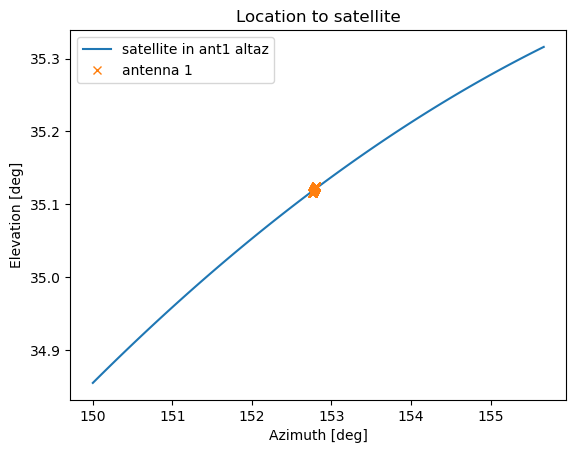

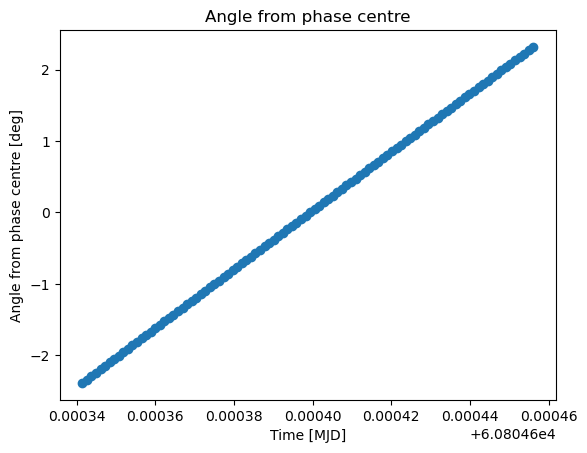

(1000, 1000) (1000, 1000)
<SkyCoord (AltAz: obstime=60804.60039932637, location=(3370869.85905276, 711565.62395684, 5349660.75110466) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (152.78395589, 35.12014646)> (1000, 1000)


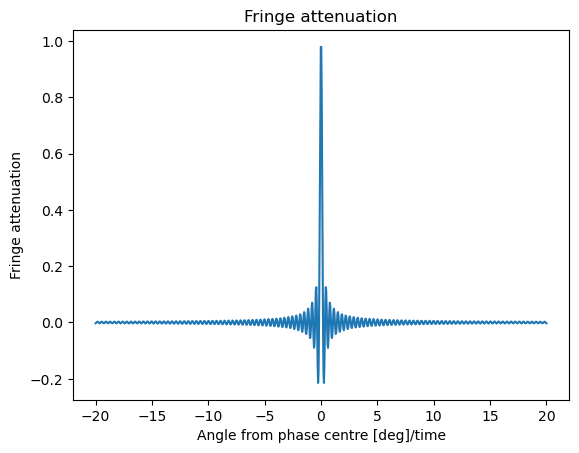

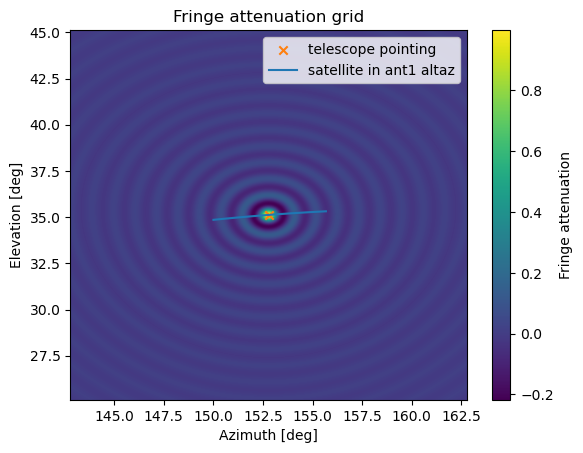

In [88]:
### get one satellite

satA_dist=test.satf_dist[:,:,:,:,:,nsat]
time = Time(mjds.flatten(), format='mjd')

#### setting up the altaz frame for the antennas
#### also get the 1-d arrays of the satellite location in altaz frame
tel_az=test.topo_pos_az[0,:,:,:,:,nsat].flatten()
tel_el=test.topo_pos_el[0,:,:,:,:,nsat].flatten()
altaz = AltAz( obstime=time, location=loc1)


plt.plot(tel_az,tel_el,label='satellite in ant1 altaz')
plt.xlabel('Azimuth [deg]')
plt.ylabel('Elevation [deg]')
plt.title('Location to satellite')


idx_t=50
tel1_sats=SkyCoord(tel_az,tel_el,unit=(u.deg,u.deg),frame=altaz)
pnt=tel1_sats[idx_t]
ra = pnt.icrs.ra.deg
dec = pnt.icrs.dec.deg
print('ideal ra dec pointing for intercept',ra,dec)
skycoord_track=SkyCoord(ra,dec, unit=u.deg,frame='icrs')
tel1_pnt=skycoord_track.transform_to(altaz) ### get the altaz coordinates of the telescope pointing
# print(tel1_pnt.shape)
# tel2_pnt=skycoord_track.transform_to(altaz2)
plt.plot(tel1_pnt.az, tel1_pnt.alt,'x',label='antenna 1')
# plt.plot(tel2_pnt.az, tel2_pnt.alt,'x',label='antenna 1')

plt.legend()
plt.show()
plt.close()


plt.title('Angle from phase centre')
offbeam=tel1_pnt.separation(tel1_sats)
offbeam[:np.argmin(offbeam)]*=-1
plt.scatter(mjds.flatten(),offbeam)
plt.xlabel('Time [MJD]')
plt.ylabel('Angle from phase centre [deg]')
plt.show()



### make powerdensity ripple grid on the sky
az=np.linspace(pnt.az.value-10,pnt.az.value+10,1000)
el=np.linspace(pnt.alt.value-10,pnt.alt.value+10,1000)
az,el=np.meshgrid(az,el)
pnt_xy=SkyCoord(pnt.az.value,pnt.alt.value,unit=(u.deg,u.deg))
print(az.shape,el.shape)
# ew_grid=obs.ew_elevation(el*u.deg,az*u.deg)
ew_grid=pnt_xy.separation(SkyCoord(az,el,unit=(u.deg,u.deg)))
print(pnt,ew_grid.shape)


plt.title('Fringe attenuation')
fringe_attenuation=obs.fringe_attenuation(baseline=baselines[2]*u.m,theta=np.linspace(-20,20,1000)*u.deg,bandwidth=5*u.MHz)
plt.plot(np.linspace(-20,20,1000), fringe_attenuation)
plt.xlabel('Angle from phase centre [deg]/time')
plt.ylabel('Fringe attenuation')
plt.show()


# fringe_grid=ew_grid.value
fringe_grid=obs.fringe_attenuation(baseline=baselines[2]*u.m,theta=ew_grid,bandwidth=2*u.MHz)
plt.scatter(pnt.az,pnt.alt,marker='x',label='telescope pointing',color='C1')
plt.plot(tel_az,tel_el,label='satellite in ant1 altaz')

plt.imshow(fringe_grid,origin='lower',extent=(az.min(),az.max(),el.min(),el.max()),aspect='auto')
plt.colorbar(label='Fringe attenuation')
plt.xlabel('Azimuth [deg]')
plt.ylabel('Elevation [deg]')
plt.title('Fringe attenuation grid')
plt.legend()
plt.savefig('satellite transit fringe far field attenuation.png')
plt.show()


(3, 100)
(100,)


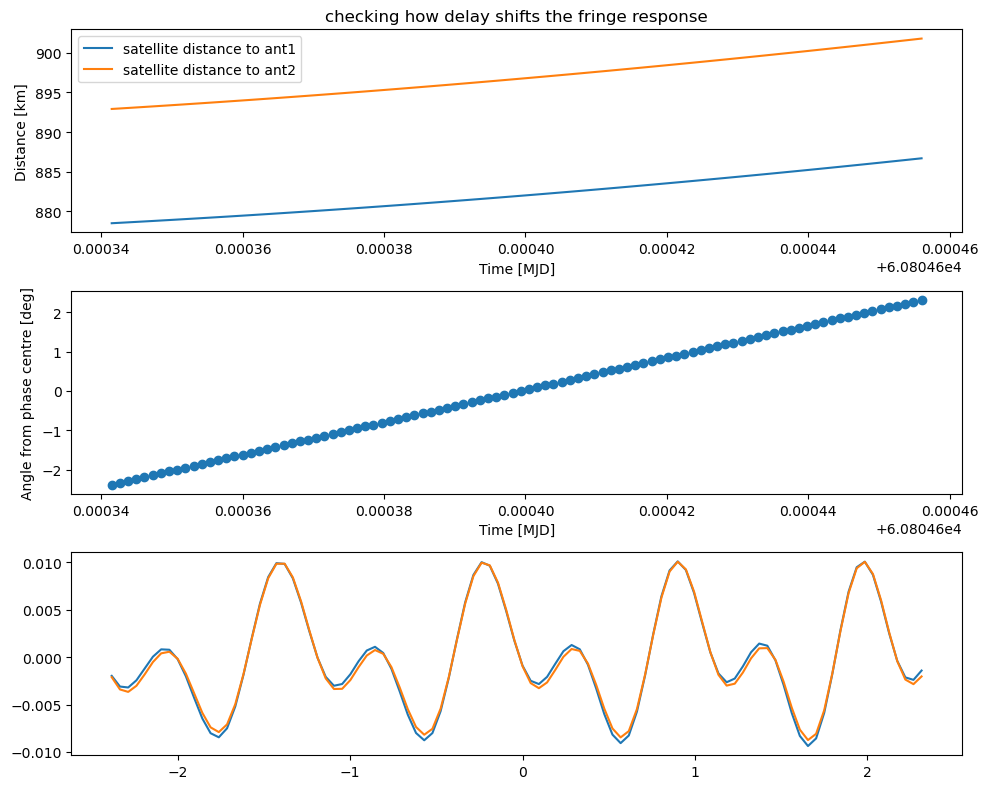

In [89]:
tel_delays=obs.mod_tau(az=tel_az,el=tel_el,lat=ant1.loc.lat,D=baselines[2]*u.m)
real_delays=obs.baseline_nearfield_delay(
                                         l1=satA_dist[0]*u.km,l2=satA_dist[2]*u.km,tau=tel_delays).flatten()

# real_delays=real_delays.reshape(len(baselines),-1)
satdelays=((satA_dist[0]*1000/3e8)-(satA_dist[1]*1000/3e8))*u.s
satdelays=satdelays.flatten()
plt.figure(figsize=(10, 8))


ax1=plt.subplot(311)
ax1.set_title('checking how delay shifts the fringe response')

ax1.plot(mjds.flatten(),satA_dist[0].flatten(),label='satellite distance to ant1')
ax1.plot(mjds.flatten(),satA_dist[2].flatten(),label='satellite distance to ant2')
ax1.legend()
ax1.set_xlabel('Time [MJD]')
# ax1.set_ylabel('Fringe response')
ax1.set_ylabel('Distance [km]')
ax2=plt.subplot(312)
plt.scatter(mjds.flatten(),offbeam)
ax2.set_xlabel('Time [MJD]')
ax2.set_ylabel('Angle from phase centre [deg]')
ax3=plt.subplot(313)
ax3.plot(offbeam,obs.bw_fringe(delays=satdelays,bwchan=100,nchan=100,fch1=100),label='fringe response')
ax3.plot(offbeam,obs.bw_fringe(delays=satdelays+2*u.s,bwchan=100,nchan=100,fch1=100),label='fringe response')

plt.tight_layout()
plt.savefig('fringe shift example.png')
plt.show()



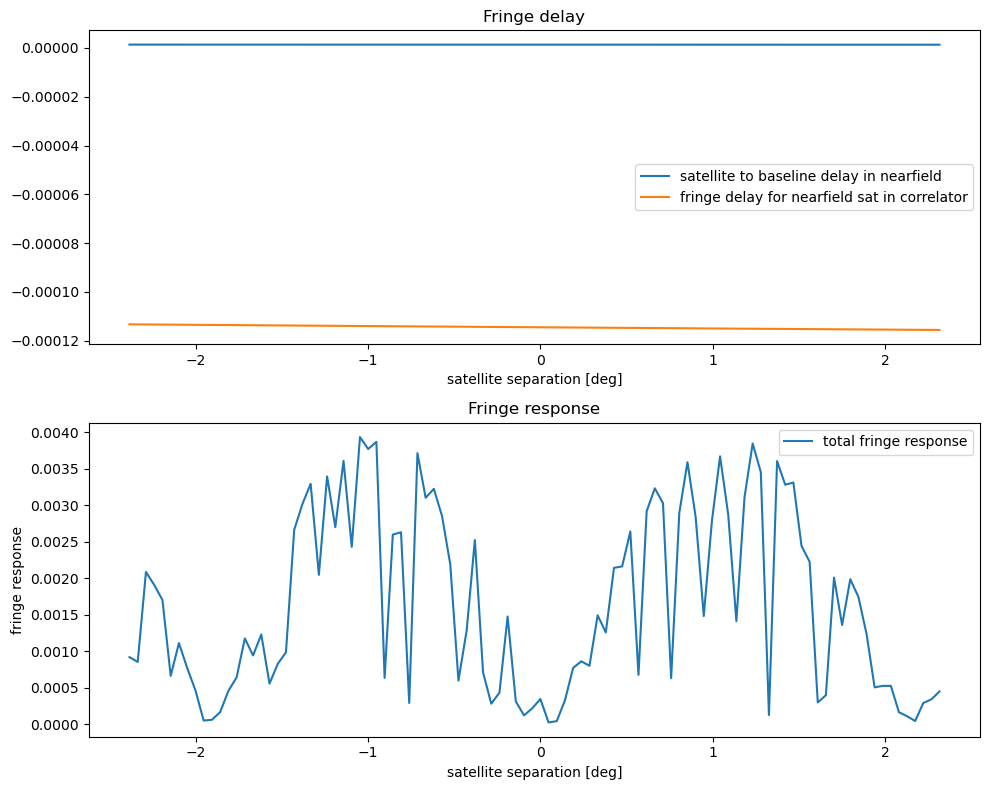

In [119]:

plt.figure(figsize=(10, 8))
ax1=plt.subplot(211)
ax1.plot(offbeam, satdelays,label='satellite to baseline delay in nearfield')
# ax1.plot(mjds.flatten(),obs.tdelay(rab,ew_alt),label='correlator delay for sky fringe attenuation')
# ax1.plot(mjds.flatten(), obs.tdelay(rab,ew_alt)-satdelays,label='fringe delay for nearfield sat in correlator')
ax1.plot(offbeam, real_delays,label='fringe delay for nearfield sat in correlator')
ax1.set_xlabel('Time [MJD]')
ax1.set_xlabel('satellite separation [deg]')

# ax1.set_ylabel('Fringe delay [s]')
ax1.set_title('Fringe delay')
# ax1.set_xlim(-40,-30)
ax1.legend()

# bwfringe = np.sum([obs.fringe_response(delay=real_delays-obs.tdelay(rab,tel2_pnt.alt),frequency=i*u\.Hz) for i in np.arange(10.7e9,10.95e9,1e6)],axis=0)
ax2=plt.subplot(212,sharex=ax1)
superfringe=np.zeros(len(mjds.flatten()))
# bands=np.arange(10.7e3,12.1e3,250)
bands=np.arange(10.7e3,10.8e3,250)
for fch1 in bands:
    bwfringe=obs.bw_fringe(delays=real_delays,bwchan=1,nchan=250,fch1=fch1)
    superfringe+=np.abs(bwfringe)
    # ax2.plot(mjds.flatten(), (np.abs(bwfringe)),label=f'{fch1/1e3:.2f} GHz')
ax2.plot(offbeam, (np.abs(superfringe)/len(bands)),label='total fringe response')
# ax2.set_xlabel('Time [MJD]')
ax2.set_xlabel('satellite separation [deg]')

ax2.set_ylabel('fringe response')
ax2.set_title('Fringe response')
ax2.legend()


plt.tight_layout()
plt.show()

In [91]:
plt.close()
star_el=test.topo_pos_el
print(star_el.shape)
### get power from satellite
satpwrpfd=(np.interp(star_el,xp=x_el,fp=y_pfd))  ###
print(satpwrpfd.shape)

(3, 1, 1, 1, 100, 1)
(3, 1, 1, 1, 100, 1)


In [92]:
ang_sep,delta_az,delta_el,obs_dist=obs.sat_frame_pointing(sat_info=test.sat_info,beam_el=20,beam_az=0)
ang_sep=test.txbeam_angsep(beam_az=20,beam_el=0)
print(ang_sep.shape)

(3, 1, 1, 1, 100, 1)


In [93]:
### find the closest satellite times for each cell
angsep=test.txbeam_angsep(0,0)
print(angsep.shape)

(3, 1, 1, 1, 100, 1)


In [94]:
test.create_baselines() ### create baselines within object
# print(test.baselines) ### show baseline combinatiosn mask
# print(test.bearing_D,test.bearings) ### show baseline combinations

In [95]:
el=test.tel_el
az=test.tel_az
lat = test.location.flatten()[0].loc.lat
l1 = test.topo_pos_dist[0][np.newaxis,:]*u.km
l2 = test.topo_pos_dist*u.km
baseline= test.bearing_D*u.m
tau1=obs.mod_tau(az,el,lat,baseline)
print(tau1.shape)

(3, 3, 1, 3659, 1, 1, 1)
(3, 1, 3659, 1, 1, 1)
(3, 1, 3659, 1, 1, 1)


In [96]:
baseline_delays=test.baselines_nearfield()
baseline_delays[:,:,:,:,idx_t,0].shape

(3, 3, 1, 3659, 1, 1, 1)
(3, 1, 3659, 1, 1, 1)
(3, 1, 3659, 1, 1, 1)


(3, 1, 3659, 1)

In [114]:
fringes=obs.bw_fringe(delays=baseline_delays[:,:,:,:,idx_t,0].reshape(3,-1),bwchan=10,nchan=10,fch1=100)
fringes[np.where(fringes==0)]=1e-12

In [115]:
fringes=np.log10(np.abs(fringes))*10

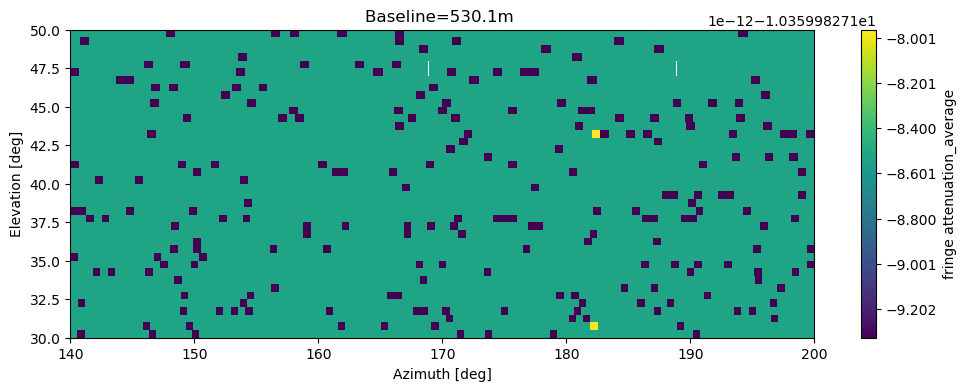

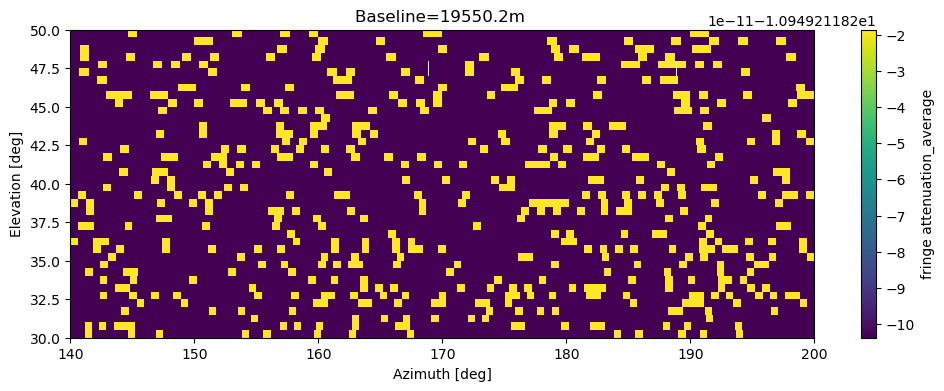

In [116]:
for i in range(test.baseline_delays.shape[0]-1):
    skynet.plotgrid(fringes[i+1,].flatten(),grid_info=grid_info,elmin=30,elmax=50,zlabel='fringe attenuation_average',
                    azmin=140,azmax=200)
    plt.title(f"Baseline={np.round(test.bearing_D.flatten()[i+1],1)}m ")
    plt.show()
    plt.close()
    